In [1]:
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configurações de visualização e alertas
sns.set_theme(style="darkgrid", palette="viridis")
plt.rcParams["figure.figsize"] = (10, 6)
import warnings
warnings.filterwarnings("ignore")

# 2. Carregamento e Pré-Processamento do Dataset

In [2]:
# Carregamento do dataset
data_path = "../data/Sample - Superstore.csv"  # Ajuste o caminho se necessário
df = pd.read_csv(data_path, encoding="latin1")

# Converter a coluna 'Order Date' para datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

# Visualizar as dimensões e as primeiras linhas do dataset
print("Dimensões do dataset:", df.shape)
display(df.head())

Dimensões do dataset: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


# 3. Cálculo das Métricas RFM (Recência, Frequência e Monetário)

In [3]:
# Agregar os dados por 'Customer ID' para calcular as métricas RFM:
# - Recency: Número de dias desde a última compra do cliente.
# - Frequency: Número de pedidos do cliente.
# - Monetary: Valor total gasto pelo cliente (Sales).
df_clientes = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (df['Order Date'].max() - x.max()).days,  # Recência
    'Order ID': 'count',                                             # Frequência
    'Sales': 'sum'                                                   # Monetário
}).reset_index()

# Renomear as colunas para português
df_clientes.columns = ['ID Cliente', 'Recência', 'Frequência', 'Monetário']

print("\nDados agregados por cliente:")
display(df_clientes.head())


Dados agregados por cliente:


,ID Cliente,Recência,Frequência,Monetário
0,AA-10315,184,11,5563.560
1,AA-10375,19,15,1056.390
2,AA-10480,259,12,1790.512
3,AA-10645,55,18,5086.935
4,AB-10015,415,6,886.156


# 4. Escalonamento dos Dados

In [4]:
features = ['Recência', 'Frequência', 'Monetário']
scaler = StandardScaler()
X = scaler.fit_transform(df_clientes[features])

# 5. Experimentação com Vários Valores de K e Plotagem do Silhouette Score

K = 2 => Silhouette Score: 0.3465
K = 3 => Silhouette Score: 0.3949
K = 4 => Silhouette Score: 0.3617
K = 5 => Silhouette Score: 0.3312
K = 6 => Silhouette Score: 0.3254


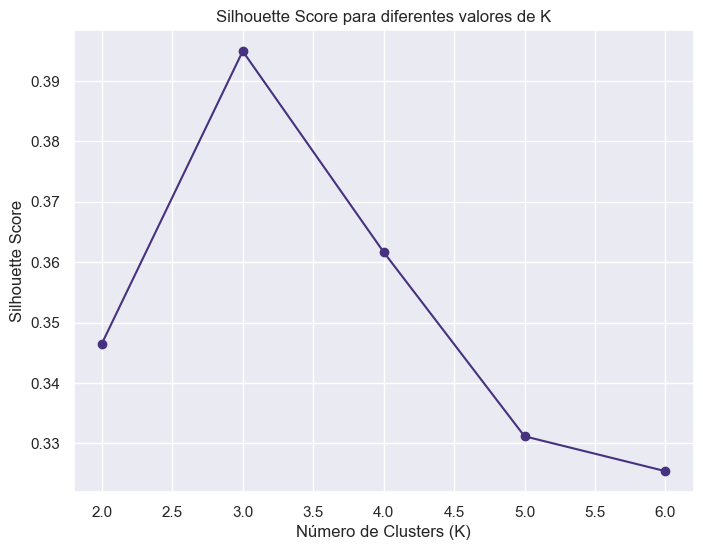

In [5]:
k_values = [2, 3, 4, 5, 6]
silhouette_scores = []

for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    clusters_temp = kmeans_temp.fit_predict(X)
    score_temp = silhouette_score(X, clusters_temp)
    silhouette_scores.append(score_temp)
    print(f"K = {k} => Silhouette Score: {score_temp:.4f}")

# Plotando o silhouette score para cada valor de K
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score para diferentes valores de K")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

# 6. Escolha do Melhor K e Aplicação do K-Means Final

In [6]:
# Seleciona o K com maior silhouette score
best_k = k_values[np.argmax(silhouette_scores)]
print(f"\nMelhor K encontrado: {best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=42)
df_clientes['Cluster'] = kmeans.fit_predict(X)

final_score = silhouette_score(X, df_clientes['Cluster'])
print(f"Silhouette Score com K = {best_k}: {final_score:.4f}")


Melhor K encontrado: 3
Silhouette Score com K = 3: 0.3949


# 7. Visualização dos Clusters

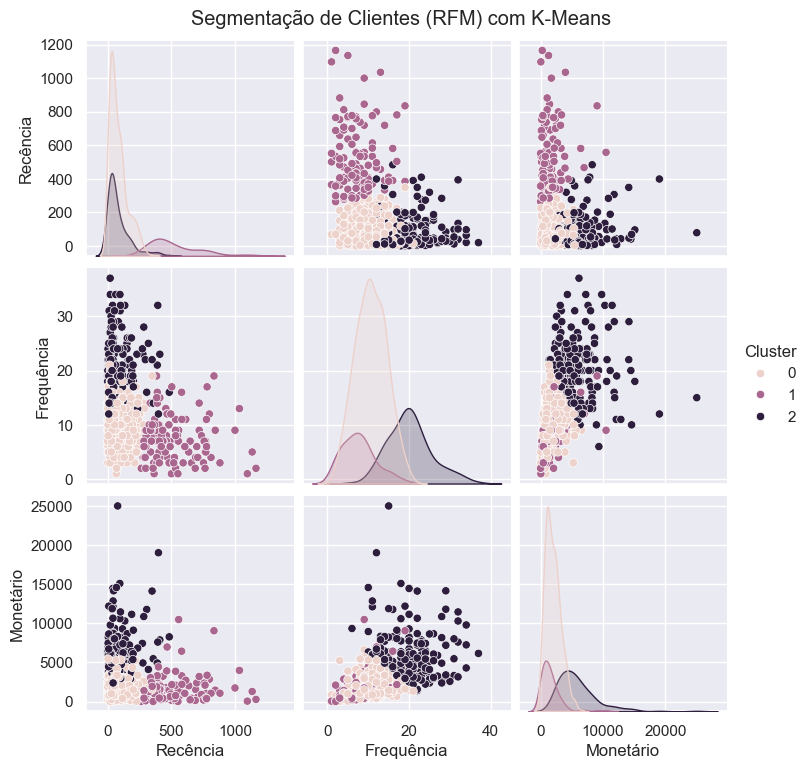

In [7]:
sns.pairplot(df_clientes, hue='Cluster', diag_kind='kde')
plt.suptitle("Segmentação de Clientes (RFM) com K-Means", y=1.02)
plt.show()

# 8. Insights Baseados na Segmentação RFM (K=3)

1. **Três Perfis Distintos de Clientes**  
   Com K=3, o algoritmo de clustering formou três grupos de clientes com características diferentes em relação às variáveis **Recência**, **Frequência** e **Monetário**. Embora o *silhouette score* seja moderado (≈0,39), ainda é possível extrair perfis relevantes para ações de marketing e vendas.

2. **Cluster de Alto Valor (Frequência e Monetário Elevados)**  
   Um dos clusters (por exemplo, o de cor roxa no pairplot) concentra clientes que compram com frequência, gastam valores elevados e realizaram compras mais recentes (baixa recência).  
   **O que fazer?**  
   - Investir em estratégias de **fidelização** e **upsell**.  
   - Oferecer programas de **recompensa** para esses clientes valiosos.

3. **Cluster de Baixo Engajamento (Alta Recência, Baixa Frequência e Monetário)**  
   Outro cluster (cor rosa) tende a agrupar clientes com a última compra distante (recência alta), poucas compras (baixa frequência) e baixo gasto total (monetário).  
   **O que fazer?**  
   - Criar **campanhas de reativação** para trazer esses clientes de volta.  
   - Oferecer **descontos** ou **ofertas especiais** para estimular novas compras.

4. **Cluster Intermediário**  
   O terceiro cluster (cor pêssego) apresenta valores intermediários de recência, frequência e monetário.  
   **O que fazer?**  
   - Focar em **cross-sell** e **upgrades** de produtos para aumentar o ticket médio.  
   - Investir em **campanhas personalizadas** que mantenham o interesse desses clientes.

5. **Silhouette Score Moderado e Próximos Passos**  
   O score de ≈0,39 indica uma separação moderada entre os clusters, sugerindo que:  
   - Pode haver **sobreposição** de perfis ou falta de variáveis adicionais.  

**Conclusão**: Mesmo com um *silhouette score* moderado, a análise RFM fornece uma visão inicial dos perfis de clientes. Cada cluster demanda estratégias específicas de marketing e vendas, tornando a segmentação uma ferramenta valiosa para aumentar a receita e a satisfação dos clientes.